# Notebook para "jugar" con los pasos de xai-LRP antes de dejar los definitivos
> No mergear con master...

### Enlace video de Eamonn de Motifs & Matrix Profiling
- Video: [youtube](https://www.youtube.com/watch?v=BYjOp2NoDdc)
- Slides: [dropbox](https://www.dropbox.com/s/i38eyidz1qo9pi3/Motifs.pptx?dl=0)

In [37]:
#Weight & Biases
import wandb

#Yaml
from yaml import load, FullLoader

#Embeddings
from dvats.all import *
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits
from fastcore.all import *

#Dimensionality reduction
from tsai.imports import *

#Clustering
import hdbscan
import os
import seaborn as sns


In [38]:
check_memory_usage = True

In [39]:
import utils.config as cfg_

In [40]:
config = cfg_.get_artifact_config_xai_lrp(False)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc2 in position 2711: ordinal not in range(128)

In [5]:
cfg_.show_attrdict(config)

use_wandb: True
wandb_group: None
wandb_entity: mi-santamaria
wandb_project: deepvats
valid_artifact: None
train_artifact: mi-santamaria/deepvats/mvp-SWV:latest
enc_artifact: mi-santamaria/deepvats/mvp-SWV:latest
n_neighbors: 15
min_dist: 0.1
random_state: 1234
metric: euclidean
cpu_flag: False
job_type: layer_relevance_propagation
allow_val_change: True
dr_artifact: None


In [6]:
api = wandb.Api()

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="05-xai-lrp_"
runname = name
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"

In [8]:
run_dr = wandb.init(
    entity           = config.wandb_entity,
    project          = config.wandb_project if config.use_wandb else 'work-nbs', 
    group            = config.wandb_group,
    allow_val_change = config.allow_val_change, 
    job_type         = config.job_type, 
    mode             = 'online' if config.use_wandb else 'disabled',
    anonymous        = 'never' if config.use_wandb else 'must',
    config           =  config,
    resume           = 'allow',
    name = runname
)
config_dr = wandb.config # Object for storing hyperparameters

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/05-xai-lrp_.ipynb.
wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


In [9]:
df, df_config, enc_artifact, enc_learner = get_dataset(config, run_dr, config_dr, True)

mvp-SWV:v66


wandb:   1 of 1 files downloaded.  


enc_artifact_train:  toy:v2
DR artifact train:  toy:v2


wandb:   1 of 1 files downloaded.  


,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [10]:
show_time_series_flag = False
if show_time_series_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [11]:
w = enc_artifact.metadata['w']
t_start = time.time()
enc_input, _ = prepare_forecasting_data(df, fcst_history = w)
t_end = time.time()
t = t_end - t_start
print("SW start | " , t_start, " | end ", t_end, "total (secs): ", t)
print(enc_input.shape)

SW start |  1707149275.4529903  | end  1707149275.453492 total (secs):  0.0005016326904296875
(520, 3, 30)


In [12]:
stride = df_config['stride']
batch_size = df_config['batch_size']

##### Check de toy ####
stride = 5
####

In [13]:
print(stride)
print(batch_size)
print(enc_input.shape)
print(enc_artifact.name)

5
None
(520, 3, 30)
mvp-SWV:v66


In [14]:
chunk_max = 10000000
shape = enc_input.shape
chunk_size_ = min(shape[1]*shape[2],chunk_max/(shape[1]*shape[2]))
N = max(3200,np.floor(chunk_size_/32))
chunk_size = N*32
chunk_size

102400

In [15]:
t_start = time.time()
embs = get_enc_embs_set_stride_set_batch_size(
    enc_input, 
    enc_learner, 
    stride     = stride,
    batch_size = batch_size,
    cpu        = config.cpu_flag,
    to_numpy   = True, 
    print_flag = False,
    time_flag  = True,
    chunk_size = chunk_size
)
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end ", t_end, "total (secs): ", t)

get_enc_embs_set_stride_set_batch_size 1.8158948421478271 seconds
GE start |  1707149275.5057397  | end  1707149277.3247843 total (secs):  1.819044589996338


In [16]:
embs.shape

(104, 128)

In [17]:
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(104, 128)

In [18]:
prjs = get_prjs(embs_no_nan, config_dr, config, False)

[I] [16:07:57.367201] Unused keyword parameter: print_flag during cuML estimator initialization
[I] [16:07:57.367871] Unused keyword parameter: n_neighbors during cuML estimator initialization
[I] [16:07:57.368003] Unused keyword parameter: min_dist during cuML estimator initialization
[I] [16:07:57.368130] Unused keyword parameter: metric during cuML estimator initialization
[I] [16:07:57.368252] Unused keyword parameter: a during cuML estimator initialization
[I] [16:07:57.368378] Unused keyword parameter: b during cuML estimator initialization
[I] [16:07:57.368499] Unused keyword parameter: target_metric during cuML estimator initialization
[I] [16:07:57.368618] Unused keyword parameter: target_n_neighbors during cuML estimator initialization
[I] [16:07:57.368739] Unused keyword parameter: n_epochs during cuML estimator initialization
[I] [16:07:57.368861] Unused keyword parameter: init during cuML estimator initialization
[I] [16:07:57.368979] Unused keyword parameter: hash_input d

In [19]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 7, #100, #100,
    'min_samples' : 3,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard'
}

In [20]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(5, 9), (3, 20), (1, 15), (2, 9), (-1, 2), (0, 22), (6, 13), (4, 14)]

In [21]:
score = cluster_score(prjs, clusters_labels, True)

Silhouette_score: 0.5959915


In [22]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs.shape[0])

In [23]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '-5973073902057433261', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([ArtifactManifestEntry(path='-5973073902057433261', digest='IXr4cLYR5IigmGfuSyIFlA==', ref='file:///home/macu/data/wandb_artifacts/-5973073902057433261', birth_artifact_id=None, size=982, extra={}, local_path=None)]))

In [24]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(5, 9), (3, 20), (1, 15), (2, 9), (-1, 2), (0, 22), (6, 13), (4, 14)]

## Anomalies simple detector: dynamic plot for determining wether a window of time series is anomalous

In [25]:
#anomaly_scores = detector(prjs_umap, clusters_labels)
anomaly_scores = detector(prjs, clusters.labels_)

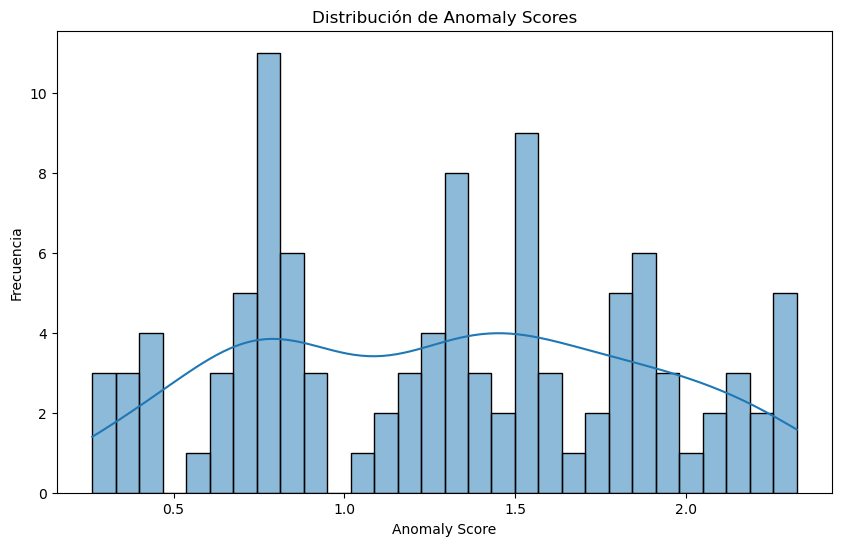

In [26]:
plot_anomaly_scores_distribution(anomaly_scores)

In [27]:
print(anomaly_scores.shape)
print("min ", np.min(anomaly_scores))
print("max ", np.max(anomaly_scores))
anomaly_scores_mean = np.mean(anomaly_scores)
print("media ", anomaly_scores_mean)
anomaly_scores_std = np.std(anomaly_scores)
print("std ", anomaly_scores_std)

(104,)
min  0.26189974
max  2.3245554
media  1.2941792
std  0.57017577


In [28]:
threshold = pd.Series(clusters.outlier_scores_).quantile(0.9)

In [29]:
import ipywidgets as widgets

In [32]:
fig_size = (7,7)
plot_clusters_with_anomalies_interactive_plot(threshold, prjs, clusters_labels, anomaly_scores, fig_size)

interactive(children=(FloatSlider(value=2.0, description='Threshold', max=3.0, min=1.0, step=0.01), Output()),…

#### Using quartiles for the scores

In [33]:
def detect_anomalies_using_iqr(scores):
    # First and third quartiles
    Q1 = np.percentile(scores, 25)
    Q3 = np.percentile(scores, 75)
    # IQR range
    IQR = Q3 - Q1
    
    #Limits for anomalies
    factor = 1.5
    lower_bound = Q1 - (factor * IQR)
    upper_bound = Q3 + (factor * IQR)
    
    # Get anomalies
    anomalies = (scores < lower_bound) | (scores > upper_bound)
    
    return anomalies, lower_bound, upper_bound

In [34]:
anomalies, lower_bound, upper_bound = detect_anomalies_using_iqr(anomaly_scores)

print("Lower Bound for Anomalies:", lower_bound)
print("Upper Bound for Anomalies:", upper_bound)

Lower Bound for Anomalies: -0.7448186278343201
Upper Bound for Anomalies: 3.314045011997223


In [35]:
def plot_data_with_anomalies(data, anomalies):
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Normal Data')
    plt.scatter(data[anomalies, 0], data[anomalies, 1], color='red', label='Anomalies')
    plt.title('Data with Anomalies highlighted')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

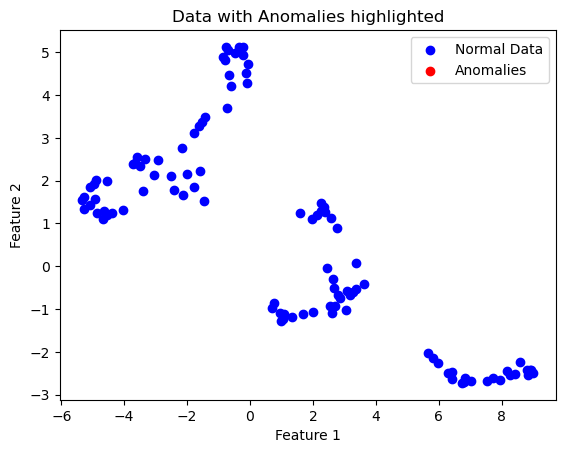

wandb: Network error (ConnectionError), entering retry loop.


In [36]:
plot_data_with_anomalies(prjs, anomalies)